In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_predict, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, mean_squared_error, r2_score, precision_score, recall_score, f1_score
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, space_eval
import xgboost as xgb

# Load in Data

In [2]:
fg_stats = pd.read_csv('fangraphs_season_level.csv')
savant = pd.read_csv('savant_pitch_level.csv')

# Data Engineering

In [3]:
savant['pitch_id'] = savant['pitcher'].astype(str) + savant['pitch_type']

savant['total_mov'] = np.sqrt(savant['pfx_x']**2 + savant['pfx_z']**2)

savant['mean_speed'] = savant.groupby('pitch_id')['release_speed'].transform('mean')
savant['mean_spin'] = savant.groupby('pitch_id')['release_spin_rate'].transform('mean')
savant['mean_pfx_x'] = savant.groupby('pitch_id')['pfx_x'].transform('mean')
savant['mean_pfx_z'] = savant.groupby('pitch_id')['pfx_z'].transform('mean')
savant['mean_total_mov'] = savant.groupby('pitch_id')['total_mov'].transform('mean')

savant['speed_pc'] = savant['release_speed'] / savant['mean_speed']
savant['spin_pc'] = savant['release_spin_rate'] / savant['mean_spin']
savant['pfx_x_pc'] = savant['pfx_x'] / savant['mean_pfx_x']
savant['pfx_z_pc'] = savant['pfx_z'] / savant['mean_pfx_z']
savant['total_mov_pc'] = savant['total_mov'] / savant['mean_total_mov']

savant['delta_speed'] = savant['release_speed'] - savant['mean_speed']
savant['delta_spin'] = savant['release_spin_rate'] - savant['mean_spin']
savant['delta_pfx_x'] = savant['pfx_x'] - savant['mean_pfx_x']
savant['delta_pfx_z'] = savant['pfx_z'] - savant['mean_pfx_z']
savant['delta_total_mov'] = savant['total_mov'] - savant['mean_total_mov']

savant['xRV'] = savant['events'].map(savant.groupby('events').mean(numeric_only=True)['delta_run_exp'])

In [4]:
# Create an opener column. If the pitcher is the starter and pitches fewer than 10 at-bats, he is an opener
savant['max_batter_faced'] = savant.groupby(['game_pk', 'pitcher'])['pitcher_at_bat_number'].transform('max')
savant['runs_scored'] = savant['post_bat_score'] - savant['bat_score']
savant['outing_runs'] = savant.groupby(['game_pk', 'pitcher'])['runs_scored'].transform('sum')

# Temporarily set opener to 1 if the pitcher is a starter, pitches fewer than 6 at-bats, and allows fewer than 3 runs
savant['opener'] = np.where((savant['role_key'] == 'SP') & (savant['max_batter_faced'] <= 6) & (savant['outing_runs'] < 3), 1, 0)

# They are a follower if come in after an opener and vice versa
savant['follower'] = np.where((savant['role_key'] == 'RP') & (savant['max_batter_faced'] > 15), savant.groupby(['game_pk','inning_topbot'])['opener'].transform('max'), 0)
savant['opener'] = np.where((savant['role_key'] == 'SP'), savant.groupby(['game_pk','inning_topbot'])['follower'].transform('max'), 0)

savant['adv_role_key'] = np.where(savant['opener'] == 1, 'OP', np.where(savant['follower'] == 1, 'FL', savant['role_key']))

In [5]:
# Find players with at least 500 pitches both with role_key as SP and RP
starter_df = savant.loc[savant['adv_role_key'] == 'SP']
reliever_df = savant.loc[savant['adv_role_key'] == 'RP']
opener_df = savant.loc[savant['adv_role_key'] == 'OP']
follower_df = savant.loc[savant['adv_role_key'] == 'FL']

reliever_opener_df = savant.loc[savant['adv_role_key'].isin(['RP', 'OP'])]
starter_follower_df = savant.loc[savant['adv_role_key'].isin(['SP', 'FL'])]

qual_starters = reliever_opener_df.groupby('player_name').filter(lambda x: len(x) >= 500)['player_name'].unique()
qual_relief = starter_follower_df.groupby('player_name').filter(lambda x: len(x) >= 500)['player_name'].unique()

hybrids = np.intersect1d(qual_starters, qual_relief)
print(len(hybrids))

95


TypeError: '>=' not supported between instances of 'float' and 'str'

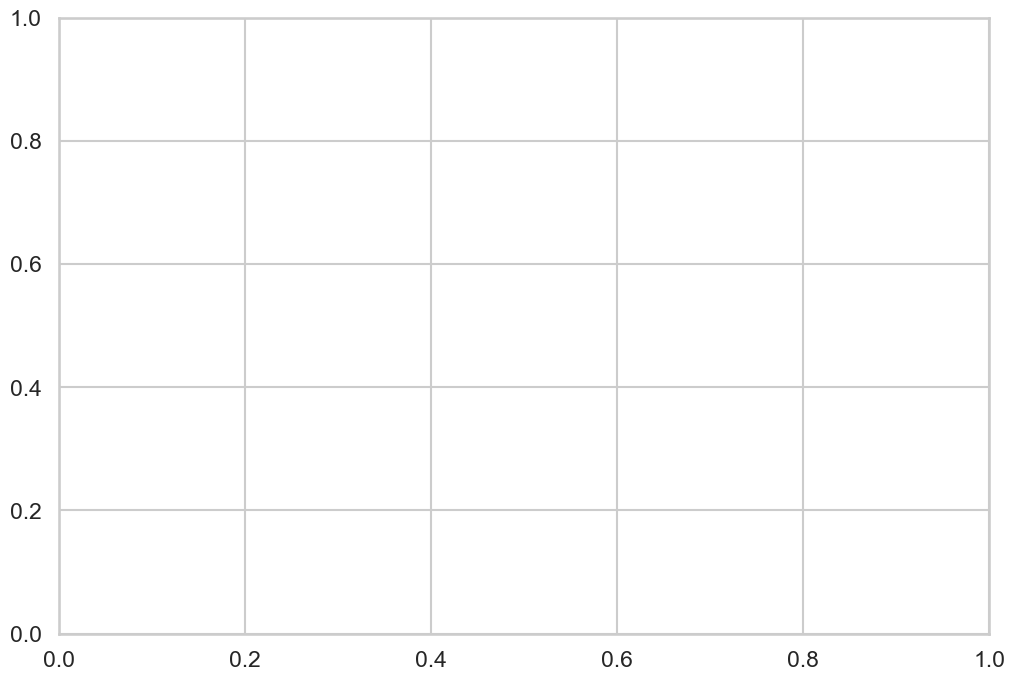

In [6]:
# Create df for op and fl
special_df = savant.loc[savant['adv_role_key'].isin(['OP', 'FL'])]

# Plot histogram of pitch_number_appearance for hybrid pitchers as OP and FL
sns.set_style('whitegrid')
sns.set_context('talk')
sns.set_palette('colorblind')

fig, ax = plt.subplots(figsize=(12, 8))
sns.histplot(data=special_df.groupby(['game_pk','pitcher']).max(), x='pitch_number_appearance', hue='adv_role_key', ax=ax)
ax.set_title('Pitch Number Appearance for Hybrid Pitchers')
ax.set_ylabel('Count')
ax.set_xlabel('Pitch Count')
plt.show()

In [ ]:
# Find the most common opener and followers
player_roles = savant.groupby(['game_pk', 'player_name', 'adv_role_key']).size().unstack(fill_value=0).reset_index()[['player_name', 'SP', 'RP', 'OP', 'FL']]
player_roles[['SP', 'RP', 'OP', 'FL']] = player_roles[['SP', 'RP', 'OP', 'FL']].clip(upper=1)
player_roles = player_roles.groupby('player_name').sum()
player_roles.corr()

In [ ]:
player_roles

In [7]:
hybrid_df = savant.loc[savant['player_name'].isin(hybrids)]

cutoff_hybrid_df = hybrid_df.loc[((hybrid_df['role_key'].isin(['SP','FO'])) & (hybrid_df['pitch_number_appearance'] <= 90)) | ((hybrid_df['role_key'].isin(['RP','OP'])) & (hybrid_df['pitch_number_appearance'] <= 50))]

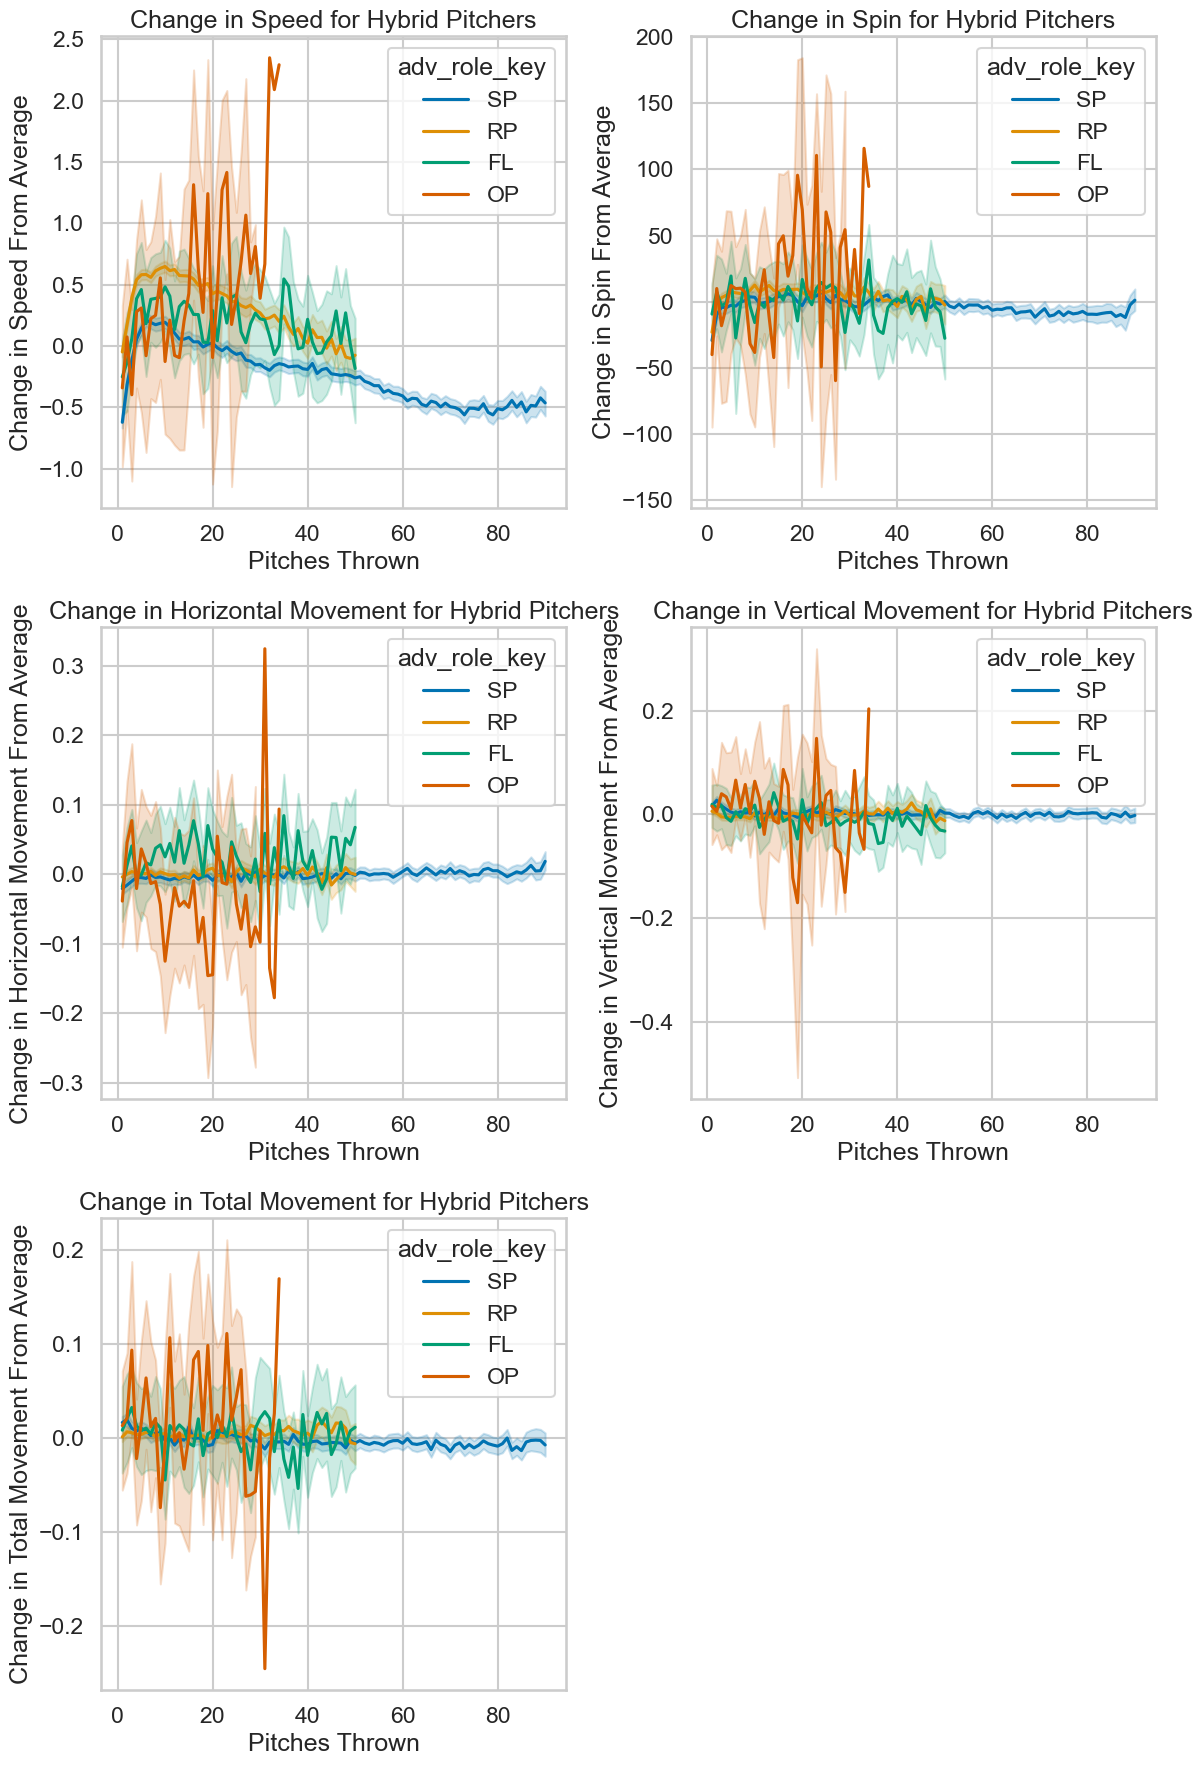

In [8]:
# Plot delta_speed for hybrid pitchers by role over time
sns.set_style('whitegrid')
sns.set_context('talk')
sns.set_palette('colorblind')

fig2, axs = plt.subplots(3, 2, figsize=(12, 18)) 
axs = axs.flatten()
i, z = 0, 0
for i, (stat, label) in enumerate(zip(['delta_speed', 'delta_spin', 'delta_pfx_x', 'delta_pfx_z', 'delta_total_mov'], ['Speed', 'Spin', 'Horizontal Movement', 'Vertical Movement', 'Total Movement'])):
    sns.lineplot(data=cutoff_hybrid_df, x='pitch_number_appearance', y=stat, hue='adv_role_key', ax=axs[i])
    axs[i].set_title(f'Change in {label} for Hybrid Pitchers')
    axs[i].set_ylabel(f'Change in {label} From Average')
    axs[i].set_xlabel('Pitches Thrown')

# Remove the last (empty) subplot if the number of plots is less than the number of subplots
if len(axs) > i+1:
    fig2.delaxes(axs[i+1])

plt.tight_layout()  # Adjust the layout so that the plots do not overlap
plt.savefig('adv_hybrid_stats.png', bbox_inches='tight')  # Save the entire figure as a single image

In [9]:
starter_df[['delta_speed', 'delta_spin', 'delta_pfx_x', 'delta_pfx_z', 'delta_total_mov']].corr()

,delta_speed,delta_spin,delta_pfx_x,delta_pfx_z,delta_total_mov
delta_speed,1.000000,0.230546,-0.073559,0.169171,0.008664
delta_spin,0.230546,1.000000,0.014422,0.071385,0.212825
delta_pfx_x,-0.073559,0.014422,1.000000,-0.041255,-0.041368
delta_pfx_z,0.169171,0.071385,-0.041255,1.000000,0.345332
delta_total_mov,0.008664,0.212825,-0.041368,0.345332,1.000000


In [10]:
# sample even number of pitches from each role and in the first 15 at bats of appearances
log_df = cutoff_hybrid_df.loc[cutoff_hybrid_df['pitcher_at_bat_number'] <= 15].dropna(subset=['delta_speed'])
sample_n = log_df.loc[(log_df['adv_role_key'] == 'SP') | (log_df['adv_role_key'] == 'RP')]['adv_role_key'].value_counts().min()

sp_sample = log_df.loc[log_df['adv_role_key'] == 'SP'].sample(sample_n)
rp_sample = log_df.loc[log_df['adv_role_key'] == 'RP'].sample(sample_n)
sp_rp_sample = pd.concat([sp_sample, rp_sample])

# Repeat for the other roles
sample_n = log_df.loc[(log_df['adv_role_key'] == 'OP') | (log_df['adv_role_key'] == 'FL')]['adv_role_key'].value_counts().min()

op_sample = log_df.loc[log_df['adv_role_key'] == 'OP'].sample(sample_n)
fl_sample = log_df.loc[log_df['adv_role_key'] == 'FL'].sample(sample_n)
op_fl_sample = pd.concat([op_sample, fl_sample])

              precision    recall  f1-score   support

          RP       0.58      0.59      0.59     31474
          SP       0.59      0.57      0.58     31750

    accuracy                           0.58     63224
   macro avg       0.58      0.58      0.58     63224
weighted avg       0.58      0.58      0.58     63224


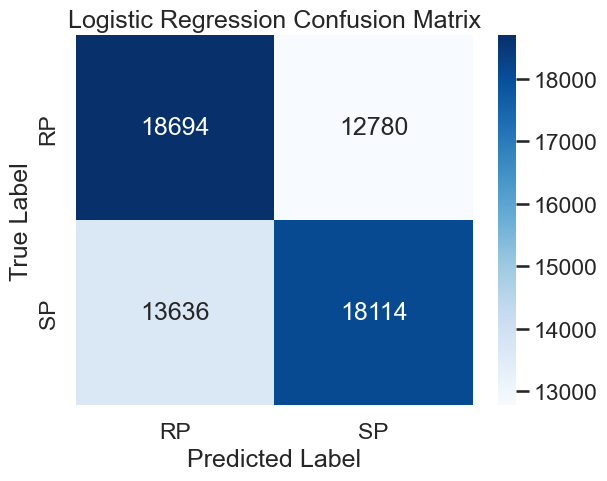

In [59]:
# Create a logistic regression model to predict role
X = sp_rp_sample[['delta_speed']]
y = sp_rp_sample['role_key']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
op_model = LogisticRegression()
op_model.fit(X_train, y_train)
predictions = op_model.predict(X_test)

print(classification_report(y_test, predictions))

cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=['RP', 'SP'], columns=['RP', 'SP'])
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Logistic Regression Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

              precision    recall  f1-score   support

          RP       0.51      0.54      0.53       281
          SP       0.52      0.48      0.50       281

    accuracy                           0.51       562
   macro avg       0.51      0.51      0.51       562
weighted avg       0.51      0.51      0.51       562


/Users/reececalvin/anaconda3/lib/python3.11/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


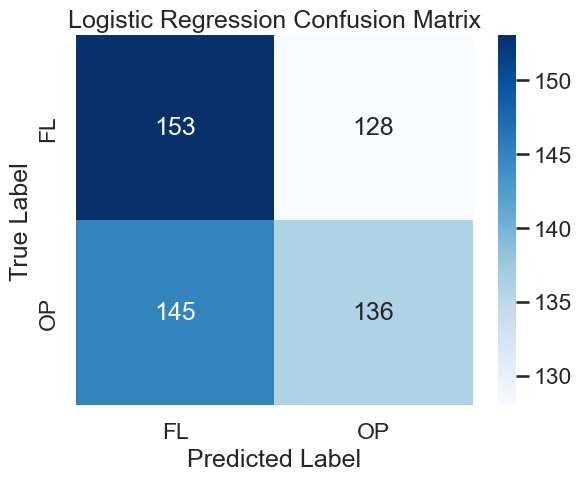

In [60]:
X = np.array(op_fl_sample[['delta_speed']])
y = op_fl_sample['role_key']

predictions = op_model.predict(X)

print(classification_report(y, predictions))

cm = confusion_matrix(y, predictions)
cm_df = pd.DataFrame(cm, index=['FL', 'OP'], columns=['FL', 'OP'])
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Logistic Regression Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [13]:
savant['adv_role_key'] = np.where(savant['opener'] == 1, 'SP', savant['adv_role_key'])
savant['adv_role_key'].value_counts()

adv_role_key
SP    1228118
RP     897577
FL      10642
Name: count, dtype: int64

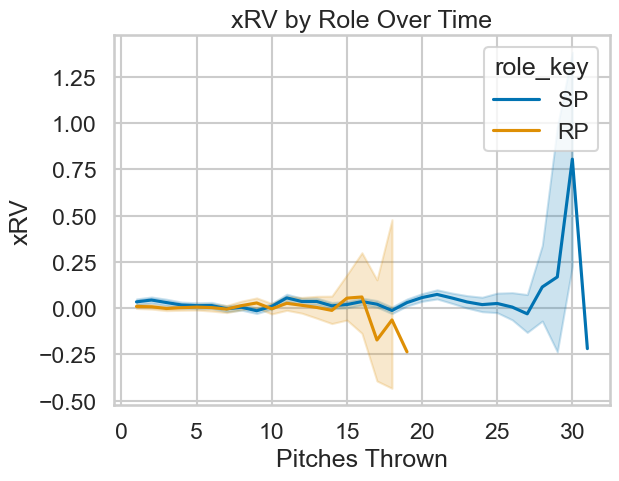

In [14]:
sns.set_style('whitegrid')
sns.set_context('talk')
sns.set_palette('colorblind')

sns.lineplot(data=cutoff_hybrid_df, x='pitcher_at_bat_number', y='xRV', hue='role_key')
plt.title('xRV by Role Over Time')
plt.ylabel('xRV')
plt.xlabel('Pitches Thrown')
plt.savefig('xRV_by_role.png', bbox_inches='tight')

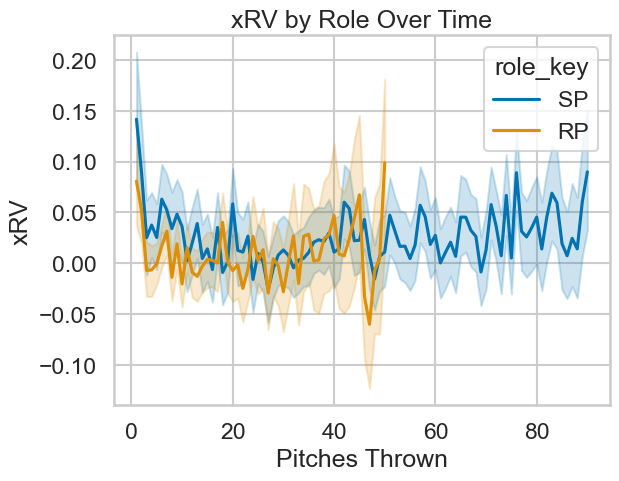

In [15]:
sns.lineplot(data=cutoff_hybrid_df.dropna(subset=['events']), x='pitch_number_appearance', y='xRV', hue='role_key')
plt.title('xRV by Role Over Time')
plt.ylabel('xRV')
plt.xlabel('Pitches Thrown')
plt.savefig('xRV_by_role.png', bbox_inches='tight')

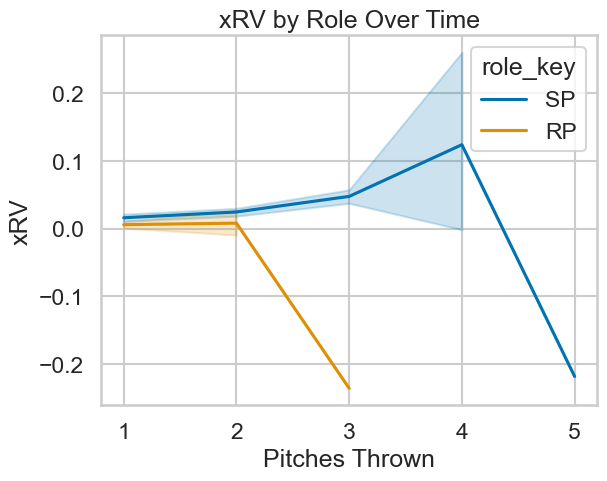

In [16]:
sns.lineplot(data=cutoff_hybrid_df.dropna(subset=['events']), x='times_faced', y='xRV', hue='role_key')
plt.title('xRV by Role Over Time')
plt.ylabel('xRV')
plt.xlabel('Pitches Thrown')
plt.savefig('xRV_by_role.png', bbox_inches='tight')

In [17]:
# For each metric in fg_stats, create a sp and rp version
sp_stats = fg_stats.loc[fg_stats['Role'] == 'SP']
rp_stats = fg_stats.loc[fg_stats['Role'] == 'RP']

In [18]:
# Find the 360th best SIERA
# 3 season, 20 teams competing, 6 starters per team anticipating 1 injury per team
comp_sp = (20*6*3)
SIERA_thresh = sp_stats['SIERA'].sort_values(ascending=True).iloc[comp_sp-1]
FIP_thresh = sp_stats['FIP'].sort_values(ascending=True).iloc[comp_sp-1]

In [19]:
hybrid_df['season'] = hybrid_df['game_date'].str[0:4].astype(int)
rp_stats['NameYear'] = rp_stats['MLBAMID'].astype(str) + rp_stats['Season'].astype(str)
sp_stats['NameYear'] = sp_stats['MLBAMID'].astype(str) + sp_stats['Season'].astype(str)
hybrid_df['NameYear'] = hybrid_df['pitcher'].astype(str) + hybrid_df['season'].astype(str)

/var/folders/gv/s6hmrh6n1tl4cf6nr2g77t140000gn/T/ipykernel_71662/3365070401.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hybrid_df['season'] = hybrid_df['game_date'].str[0:4].astype(int)
/var/folders/gv/s6hmrh6n1tl4cf6nr2g77t140000gn/T/ipykernel_71662/3365070401.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rp_stats['NameYear'] = rp_stats['MLBAMID'].astype(str) + rp_stats['Season'].astype(str)
/var/folders/gv/s6hmrh6n1tl4cf6nr2g77t140000gn/T/ipykernel_71662/3365070401.py:3: SettingWithCopyWarni

In [20]:
sp_stats = sp_stats.loc[sp_stats['NameYear'].isin(hybrid_df['NameYear'].unique())]
rp_stats = rp_stats.loc[rp_stats['NameYear'].isin(hybrid_df['NameYear'].unique())]

In [21]:
rp_stats['spSIERA'] = rp_stats['NameYear'].map(sp_stats.set_index('NameYear')['SIERA'])
rp_stats['spFIP'] = rp_stats['NameYear'].map(sp_stats.set_index('NameYear')['FIP'])

In [22]:
pitch_cols = ['FA_pct_sc', 'SL_pct_sc', 'SI_pct_sc', 'CU_pct_sc', 'FC_pct_sc', 'CH_pct_sc', 'FS_pct_sc', 'KC_pct_sc', 'KN_pct_sc', 'EP_pct_sc', 'FO_pct_sc', 'SC_pct_sc', 'UN_pct_sc']

rp_stats[pitch_cols] = rp_stats[pitch_cols].apply(pd.to_numeric)

# Get top 6 pitches in order
top_pitches = rp_stats[pitch_cols].apply(lambda x: x.nlargest(6).index.tolist(), axis=1)

# Get top 6 frequencies in order
top_freqs = rp_stats[pitch_cols].apply(lambda x: x.nlargest(6).tolist(), axis=1)

# Add new columns
rp_stats['1Pitch'] = top_pitches.str[0]
rp_stats['2Pitch'] = top_pitches.str[1]
rp_stats['3Pitch'] = top_pitches.str[2]
rp_stats['4Pitch'] = top_pitches.str[3]
rp_stats['5Pitch'] = top_pitches.str[4]
rp_stats['6Pitch'] = top_pitches.str[5]

rp_stats['1PitchFreq'] = top_freqs.str[0]
rp_stats['2PitchFreq'] = top_freqs.str[1]
rp_stats['3PitchFreq'] = top_freqs.str[2]
rp_stats['4PitchFreq'] = top_freqs.str[3]
rp_stats['5PitchFreq'] = top_freqs.str[4]
rp_stats['6PitchFreq'] = top_freqs.str[5]

pitch_dict = {'FO_pct_sc' : 'FA_pct_sc', 'SC_pct_sc' : 'SL_pct_sc'}
def get_pitch_stuff(x,n):
    pitch = x[f'{n}Pitch']
    if pitch in pitch_dict.keys():
        pitch = pitch_dict[pitch]
    if str(pitch)[0:2] in ['EP','KN','UN']:
        stuff = 60
    elif pitch is np.nan:
        stuff = np.nan
    else:
        stuff = x[f'botStf_{pitch[0:2]}']
    return stuff

rp_stats['1StuffVal'] = rp_stats.apply(lambda x: get_pitch_stuff(x,1), axis=1)
rp_stats['2StuffVal'] = rp_stats.apply(lambda x: get_pitch_stuff(x,2), axis=1)
rp_stats['3StuffVal'] = rp_stats.apply(lambda x: get_pitch_stuff(x,3), axis=1)
rp_stats['4StuffVal'] = rp_stats.apply(lambda x: get_pitch_stuff(x,4), axis=1)
rp_stats['5StuffVal'] = rp_stats.apply(lambda x: get_pitch_stuff(x,5), axis=1)
rp_stats['6StuffVal'] = rp_stats.apply(lambda x: get_pitch_stuff(x,6), axis=1)

def get_pitch_cmd(x,n):
    pitch = x[f'{n}Pitch']
    if pitch in pitch_dict.keys():
        pitch = pitch_dict[pitch]
    if str(pitch)[0:2] in ['EP','KN','UN']:
        cmd = 60
    elif pitch is np.nan:
        cmd = np.nan
    else:
        cmd = x[f'botCmd_{pitch[0:2]}']
    return cmd

rp_stats['1CmdVal'] = rp_stats.apply(lambda x: get_pitch_cmd(x,1), axis=1)
rp_stats['2CmdVal'] = rp_stats.apply(lambda x: get_pitch_cmd(x,2), axis=1)
rp_stats['3CmdVal'] = rp_stats.apply(lambda x: get_pitch_cmd(x,3), axis=1)
rp_stats['4CmdVal'] = rp_stats.apply(lambda x: get_pitch_cmd(x,4), axis=1)
rp_stats['5CmdVal'] = rp_stats.apply(lambda x: get_pitch_cmd(x,5), axis=1)
rp_stats['6CmdVal'] = rp_stats.apply(lambda x: get_pitch_cmd(x,6), axis=1)

In [23]:
rp_stats['nPitches'] = rp_stats[pitch_cols].apply(lambda x: len(x[x >= .08]), axis=1)

In [24]:
rp_stats['SClass'] = np.where(rp_stats['spSIERA'] <= SIERA_thresh, 1, 0)
display(rp_stats['SClass'].value_counts())

rp_stats['FClass'] = np.where(rp_stats['spFIP'] <= FIP_thresh, 1, 0)
display(rp_stats['FClass'].value_counts())

SClass
0    172
1     47
Name: count, dtype: int64

FClass
0    180
1     39
Name: count, dtype: int64

In [25]:
feats = ['1Pitch', '2Pitch', '3Pitch', '4Pitch', '5Pitch', '6Pitch', '1PitchFreq', '2PitchFreq', '3PitchFreq', '4PitchFreq', '5PitchFreq', '6PitchFreq', 'nPitches', 'K_pct', 'BB_pct', 'GB_pct', 'FB_pct', 'OSwing_pct', 'ZSwing_pct', 'OContact_pct', 'ZContact_pct', 'SwStr_pct', 'CStr_pct', 'CSW_pct', 'Barrel_pct', 'HardHit_pct', 'HR_to_FB_pct_plus', '1StuffVal','2StuffVal','3StuffVal','4StuffVal','5StuffVal','6StuffVal', '1CmdVal', '2CmdVal', '3CmdVal', '4CmdVal', '5CmdVal', '6CmdVal','Throws']

In [26]:
rp_stats_qual = rp_stats.loc[rp_stats['IP'] >= 15]
sp_stats_qual = sp_stats.loc[sp_stats['IP'] >= 15]
rp_stats_qual = rp_stats_qual.loc[rp_stats_qual['NameYear'].isin(sp_stats_qual['NameYear'].unique())]
sp_stats_qual = sp_stats_qual.loc[sp_stats_qual['NameYear'].isin(rp_stats_qual['NameYear'].unique())]

Average ROC AUC: 0.5028
Test ROC AUC: 0.6513
              precision    recall  f1-score   support

           0       0.84      0.91      0.87        34
           1       0.25      0.14      0.18         7

    accuracy                           0.78        41
   macro avg       0.54      0.53      0.53        41
weighted avg       0.74      0.78      0.76        41


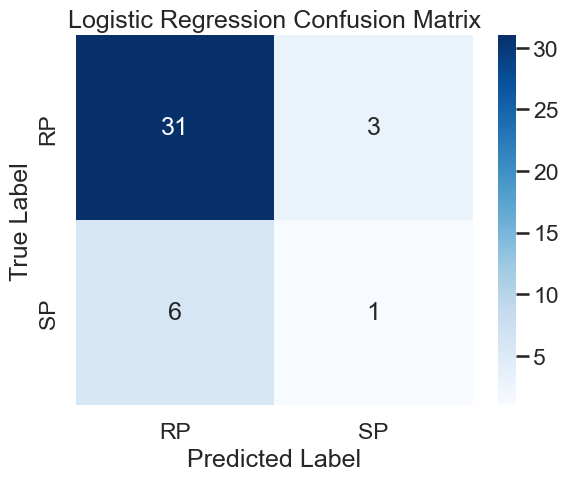

In [27]:
# Create a logistic regression model to predict role
X = rp_stats_qual[feats]

y = rp_stats_qual['SClass']

# One hot encode '1Pitch', '2Pitch', '3Pitch', '4Pitch', '5Pitch', '6Pitch'
X = pd.get_dummies(X).fillna(0)

# Scale data
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

# Create a logistic regression model
log_model = LogisticRegression()

# Perform cross-validation predictions
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# Score on AVG ROC AUC
probabilities = cross_val_predict(log_model, X, y, cv=cv, method='predict_proba')

# Calculate average ROC AUC
average_roc_auc = roc_auc_score(y, probabilities[:, 1])

print(f'Average ROC AUC: {average_roc_auc:.4f}')

# Train the logistic regression model on the training set
log_model.fit(X_train, y_train)

# Predict probabilities on the test set
test_probabilities = log_model.predict_proba(X_test)[:, 1]

# Calculate ROC AUC on the test set
test_roc_auc = roc_auc_score(y_test, test_probabilities)

print(f'Test ROC AUC: {test_roc_auc:.4f}')

# Evaluate the model
predictions = log_model.predict(X_test)
print(classification_report(y_test, predictions))

# Plot the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=['RP', 'SP'], columns=['RP', 'SP'])
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Logistic Regression Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

Average ROC AUC: 0.6476
Test ROC AUC: 0.6261
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        34
           1       1.00      0.14      0.25         7

    accuracy                           0.85        41
   macro avg       0.93      0.57      0.58        41
weighted avg       0.88      0.85      0.80        41


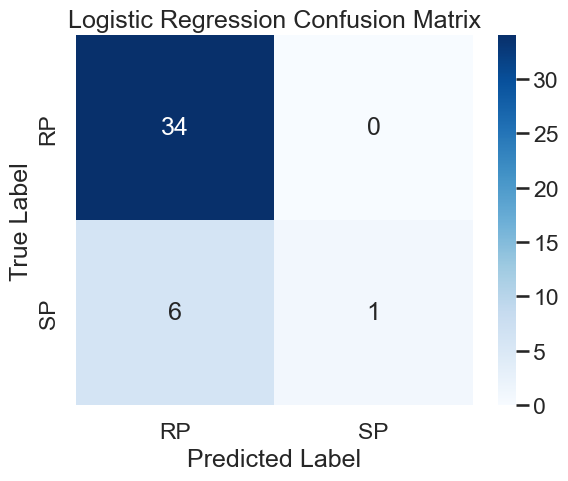

In [28]:
# Create a logistic regression model to predict role
X = rp_stats_qual[feats]

y = rp_stats_qual['FClass']

# One hot encode '1Pitch', '2Pitch', '3Pitch', '4Pitch', '5Pitch', '6Pitch'
X = pd.get_dummies(X).fillna(0)

# Scale data
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

# Create a logistic regression model
log_model = LogisticRegression()

# Perform cross-validation predictions
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)
# Score on AVG ROC AUC
probabilities = cross_val_predict(log_model, X, y, cv=cv, method='predict_proba')

# Calculate average ROC AUC
average_roc_auc = roc_auc_score(y, probabilities[:, 1])

print(f'Average ROC AUC: {average_roc_auc:.4f}')

# Train the logistic regression model on the training set
log_model.fit(X_train, y_train)

# Predict probabilities on the test set
test_probabilities = log_model.predict_proba(X_test)[:, 1]

# Calculate ROC AUC on the test set
test_roc_auc = roc_auc_score(y_test, test_probabilities)

print(f'Test ROC AUC: {test_roc_auc:.4f}')

# Evaluate the model
predictions = log_model.predict(X_test)
print(classification_report(y_test, predictions))

# Plot the confusion matrix
cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=['RP', 'SP'], columns=['RP', 'SP'])
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('Logistic Regression Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
y = rp_stats_qual['spFIP']
X = rp_stats[feats]
X = pd.get_dummies(X).fillna(0)
X['NameYear'] = rp_stats['NameYear']
X = X.loc[X['NameYear'].isin(rp_stats_qual['NameYear'].unique())]
X = X.drop(columns=['NameYear'])

# Define the parameter grid for grid search
param_grid = {
    'n_estimators': range(100, 1000, 100),
    'max_depth': range(1, 20),
    'learning_rate': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5],
    'gamma': [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
}

# Instantiate XGBRegressor
reg_model = xgb.XGBRegressor()

# Create GridSearchCV object
grid_search = GridSearchCV(reg_model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Instantiate XGBRegressor with the best hyperparameters
reg_model = xgb.XGBRegressor(**best_params)

# Train the model
reg_model.fit(X_train, y_train)

# Predict and evaluate the model
y_pred = reg_model.predict(X_test)

# Print MSE and R2 scores
print(f'MSE: {mean_squared_error(y_test, y_pred)}')
print(f'R2: {r2_score(y_test, y_pred)}')


In [ ]:
y = rp_stats_qual['FClass']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

# Hyperparameter tuning with F1 score as objective
def objective(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    params['learning_rate'] = float(params['learning_rate'])
    params['gamma'] = float(params['gamma'])
    model = xgb.XGBClassifier(**params)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return -f1_score(y_test, y_pred, average='weighted')


best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            max_evals=100)

best['max_depth'] = range(1, 20)[best['max_depth']]

# Train final model with best hyperparameters
clf_model = xgb.XGBClassifier(**best)
clf_model.fit(X_train, y_train)

# Evaluate on F1 score
y_pred = clf_model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')

print(f'F1 Score: {f1:.4f}')

# Evaluate on precision and recall
precision = precision_score(y_test, y_pred, average='weighted')
recall = recall_score(y_test, y_pred, average='weighted')

print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

# Plot the confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, index=['RP', 'SP'], columns=['RP', 'SP'])
sns.heatmap(cm_df, annot=True, cmap='Blues', fmt='g')
plt.title('XGBoost Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [ ]:
# Create a xgboost regression model to predict role
y = rp_stats_qual['spFIP']
X = rp_stats[feats]
X = pd.get_dummies(X).fillna(0)
X['NameYear'] = rp_stats['NameYear']
X = X.loc[X['NameYear'].isin(rp_stats_qual['NameYear'].unique())]
X = X.drop(columns=['NameYear'])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=1)

#hyper fit XGBRegressor parameters
def objective(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_estimators'] = int(params['n_estimators'])
    params['learning_rate'] = float(params['learning_rate'])
    params['gamma'] = float(params['gamma'])
    model = xgb.XGBRegressor(**params)
    model.fit(X_train,y_train)
    y_pred = model.predict(X_test)
    return mean_squared_error(y_test,y_pred)

space = {
    'n_estimators': hp.choice('n_estimators', range(100,1000, 100)),
    'max_depth': hp.choice('max_depth', range(1,20)),
    'learning_rate': hp.quniform('learning_rate', .01, .5, .01),
    'gamma': hp.quniform('gamma', 0, 1, .01),
}

best = fmin(fn=objective,
                     space=space,
                     algo=tpe.suggest,
                     max_evals=50)

best['n_estimators'] = range(100,1000, 100)[best['n_estimators']]
best['max_depth'] = range(1,20)[best['max_depth']]

reg_model = xgb.XGBRegressor(**best)

reg_model.fit(X_train,y_train)

y_pred = reg_model.predict(X_test)

print(f'MSE: {mean_squared_error(y_test,y_pred)}')
print(f'R2: {r2_score(y_test,y_pred)}')

In [ ]:
# Create a xgboost regression model to predict role
y = rp_stats_qual['spFIP']
X = rp_stats[feats]
X = pd.get_dummies(X).fillna(0)
X['NameYear'] = rp_stats['NameYear']
X = X.loc[X['NameYear'].isin(rp_stats_qual['NameYear'].unique())]
X = X.drop(columns=['NameYear'])

In [ ]:
def plot_feat_import(model):
    # Plotting feature importance
    feat_importance = model.feature_importances_
    feat_names = X.columns
    
    # Combine one-hot encoded columns
    combined_feat_importance = []
    combined_feat_names = []
    
    # combine feats of previous one-hot encoded columns
    for feat in feat_names:
        if '_' in feat:
            original_feat = feat.split('_')[0]
            if original_feat not in combined_feat_names:
                combined_feat_names.append(original_feat)
                combined_feat_importance.append(feat_importance[X.columns.get_loc(feat)])
            else:
                combined_feat_importance[combined_feat_names.index(original_feat)] += feat_importance[X.columns.get_loc(feat)]
        else:
            combined_feat_names.append(feat)
            combined_feat_importance.append(feat_importance[X.columns.get_loc(feat)])
    
    combined_feat_importance = np.array(combined_feat_importance)
    combined_feat_names = np.array(combined_feat_names)
    
    combined_indices = np.argsort(combined_feat_importance)[::-1]
    
    top_n = 10
    top_combined_feat_importance = combined_feat_importance[combined_indices][:top_n]
    top_combined_feat_names = combined_feat_names[combined_indices][:top_n]
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x=top_combined_feat_importance, y=top_combined_feat_names)
    plt.title('Top Combined Feature Importance')
    plt.xlabel('Feature Importance')
    plt.ylabel('Feature Names')
    plt.show()

In [ ]:
#plot_feat_import(reg_model)
plot_feat_import(clf_model)

In [ ]:
non_hybrid_df = rp_stats.loc[(rp_stats['IP'] > 20) & ~(rp_stats['NameYear'].isin(rp_stats_qual['NameYear'].unique())) & (rp_stats['Season'] == 2023) & (rp_stats['Age'] < 30)]

X = pd.get_dummies(rp_stats[feats])
X['NameYear'] = rp_stats['NameYear']
X = X.loc[X['NameYear'].isin(non_hybrid_df['NameYear'].unique())]
X = X.drop(columns=['NameYear'])
non_hybrid_df['Class Score'] = clf_model.predict_proba(X)[:,1]
non_hybrid_df['xspFIP'] = reg_model.predict(X)

In [ ]:
clf_model.save_model('rp_to_sp_clf.model')
reg_model.save_model('rp_to_sp_reg.model')

In [ ]:
non_hybrid_df.sort_values('Class Score', ascending=False).head(10)[['Name','Age','Season','Class Score','xspFIP']]